# <u>**1994 Wage Inequality Among US Citizens Based on Annual Income**

#### Authors: Danielle Keith, Sam Chin, Jason Zheng

## <u>Introduction

**Background:** The 1990s saw a major economic boom in the US. Fueled by a rise in tech, the economy grew at 3% with low unemployment and 2 million new jobs (Nasar, 1994). The federal minimum wage increased to a luxurious \$4.25 and hour with an approximate 8,840 dollar annual pre-taxed income for full-time employees (U.S. Department of Labor, 2024). While income increased in 1994, minorities and women still faced significant wage inequality (Autor, 2008). This highlights that economic prosperity didn't necessarily translate to equal pay for all groups.

**Hypothesis:** Through the use of classification, an analysis of the categorical 1994 census data set will allow us to predict whether a given person's income is greater or lesser than/equal to $50,000 based on factors like level of education, age, sex, race, native country, and hours worked per week.

**Dataset:** We will be using the `Adult` dataset taken from https://archive.ics.uci.edu/dataset/2/adult, which has extracted 32,560 entries from the 1994 US census, which is a mandatory survey that collects data from all US citizens. Of the 32,560 rows, each observation represents a single person and their various attributes. There are 15 columns each signifying a different defining factor.

- `age`: age of individual
 - `workclass`: employment status (ex. self-employed, private, unemployed)
 - `fnlwgt`: final weight or the number of people this individual's entry represents
 - `education`: the highest level of education completed (ex. 12th grade, Bachelor's, Doctorate)
 - `education-num`: the highest level of education completed in numerical form 
 - `marital-status`: marital status (ex. married, single)
 - `occupation`: general type of occupation held (ex. sales, services, etc.)
 - `relationship`: primary relationship to others (ex. wife, husband, relative)
 - `race`: racial identity (ex. white, black, asian)
 - `sex`: biological sex (ex. male, female)
 - `capital-gain`: money earned on investments 
 - `capital-loss`: money lost on investments 
 - `hours-per-week`: hours at work each week
 - `native-country`: country of origin (ex. United States, India, Cuba)
 - `income`: annual income in USD (binary, <= 50k, >50k)

## <u>Methods and Results

In [1]:
# Loading libraries
library(tidyverse)
library(repr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# Reading downloaded csv file
adult <- read_csv("data/adult.csv")

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Data Wrangling:

In [120]:
# Setting seed
set.seed(3456) 

# Adding column names
colnames(adult) <- c('age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                     'marital_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')

# Many of the predictors are categorical so we need to convert them into numerical values
# in order to perform classification
adult_numerical <- adult |>
    select(race, sex, native_country) |>
    mutate(across(race:native_country, as.factor)) |>
    sapply(unclass) 
adult_final <- adult |>
    select(age, education_num, hours_per_week, income)
adult_final <- cbind(adult_final, adult_numerical) |>
    mutate(income = as_factor(income))


# Generating tables to help us convert predictors from categorical to numerical
colnames(adult_numerical) <- c('age', 'workclass', 'native')
country_convert <- cbind(adult, adult_numerical) |>
    select(native_country, native) |> 
    group_by(native_country) |>
    summarize(native_country_number = mean(native))
education_convert <- adult |>
    select(education_num, education) |>
    group_by(education) |>
    summarize(education_num = mean(education_num)) |>
    arrange(education_num)


# Reduce the amount of data, since there is currently way too much data to compute
# Additionally, we want the same amount of data for each target result. Thus we get
# 1000 rows with >50k and 1000 rows with <=50k
adult_final <- adult_final |>
    group_by(income) |>
    sample_n(1000) |>
    ungroup()

# Getting the training data
# Randomly take 75% of the data in the training set. 
adult_split <- initial_split(adult_final, prop = 0.75, strata = income)  
adult_train <- training(adult_split)   
adult_test <- testing(adult_split)

### Data Summary and Visualization:

In [121]:
# We will take the mean of our numerical predictors and the mode of our categorical predictors
analysis_mean <- adult_train |>
    select(age, hours_per_week) |>
    map_df(mean, na.rm = TRUE)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

analysis_mode <- adult |>
    select(workclass, education, marital_status, occupation, relationship, race, sex, native_country) |>
    map_df(getmode)

# Mean value of our numerical predictors
analysis_mean
# Most frequent value of our categorical predictors 
analysis_mode

age,hours_per_week
<dbl>,<dbl>
41.05667,42.644


workclass,education,marital_status,occupation,relationship,race,sex,native_country
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States


The first table (**Table 1**) represents the mean age and hours worked of the whole population while the second table (**Table 2**) is the mode of all variables in the data set. Putting these two together gives us an idea of what the average person was back in the 1990s. Interestingly, the predominant responses received in this data set came from white married men born in the United States, who are the control group that most of the data analysis comparisons will be made against. 

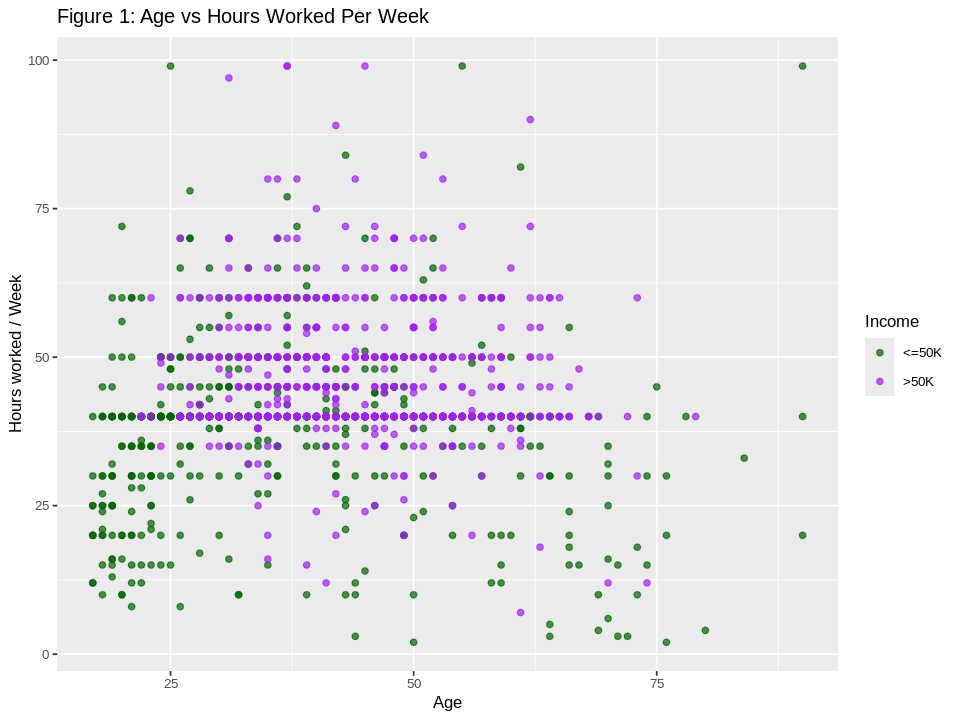

In [130]:
# Data visualization 
# Scatter plot of Age vs Hours Per Week
options(repr.plot.width=8, repr.plot.height=6)

# Generate plot of Age vs Hours with Coloured Income
age_vs_hrs <- adult_train |>
    ggplot(aes(x = age, y = hours_per_week, colour = income)) +
    geom_point(alpha = 0.7) +
    labs(x = "Age", y = "Hours worked / Week", colour = "Income") +
    scale_color_manual(values = c("dark green", "purple")) +
    ggtitle("Figure 1: Age vs Hours Worked Per Week") +
    theme(text = element_text(size = 10))

age_vs_hrs

As you can see in **Figure 1** above, being in the age range 30-50 and working around 40-70 hours per week will give you the highest chance of making more that 50,000 dollars. However, the two groups aren't very distinct, meaning there are likely other factors affecting income, which is why we want to use more than just Age and Hours Worked to predict.

### Data Analysis:

Since we are doing classification, the first step in creating our model should be finding the best value of k. Additionally, we want to scale our predictors because some variables like `sex` are only in the range (0-1) while `native_country` is from (0-42). We want both of these predictors to have the same importance so we need to scale.

In [124]:
# Creating recipe and scaling predictors
income_recipe <- recipe(income ~ ., data = adult_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Creating model to perform tuning
income_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Cross-validation and grid creation
income_vfold <- vfold_cv(adult_train, v = 5, strata = income)
income_grid <- tibble(neighbors = c(1:30))

# Creating workflow and tuning
income_workflow <- workflow() |>
    add_recipe(income_recipe) |>
    add_model(income_spec) |>
    tune_grid(resamples = income_vfold, grid = income_grid)

# Collecting tuning metrics
income_metrics <- collect_metrics(income_workflow)

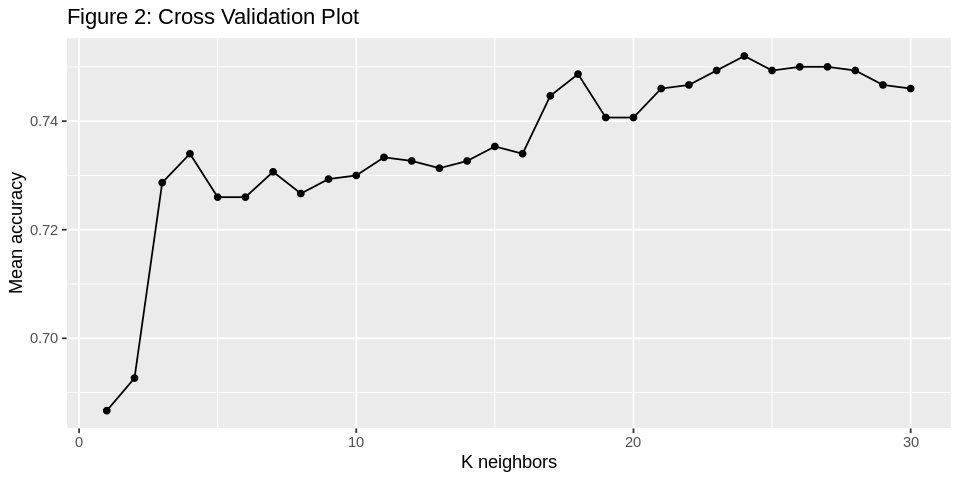

In [125]:
# Creating cross validation plot
options(repr.plot.width=8, repr.plot.height=4)

income_metrics <- income_metrics |>
    filter(.metric == "accuracy")
cross_val_plot <- income_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    xlab("K neighbors") +
    ylab("Mean accuracy") +
    ggtitle("Figure 2: Cross Validation Plot")
cross_val_plot

Looking at our Cross Validation Plot (**Figure 2**), we can see that the plot reaches it's max around k = 18 and begins to plateau. Going past k = 18 only results in small increases in accuracy, thus we can choose k = 18 as our k.

In [128]:
# Creating a tuned model and fit with 18 neighbors 
tuned_income_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
    set_engine("kknn") |>
    set_mode("classification")

tuned_income_workflow <- workflow() |>
    add_model(tuned_income_spec) |>
    add_recipe(income_recipe) |>
    fit(data = adult_train)

In [129]:
# Assessing model accuracy with testing data
income_predictions <- tuned_income_workflow |>
    predict(adult_test) |>
    bind_cols(adult_test)
income_metrics <- income_predictions |>
    metrics(truth = income, estimate = .pred_class)
income_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.722
kap,binary,0.444


Looking at the table above (**Table 3**) we can see that our model has a fairly good accuracy of 72% when predicting the testing data. Thus we can be fairly confident in the results our model predicts.

In [10]:
# Performing analysis into the data
average <- tibble(race = 5, 
                   sex = 2, 
                   native_country = 40, 
                   age = 37, 
                   education_num = 9, 
                   hours_per_week = 40)
average_prediction <- tuned_income_workflow |>
    predict(average) |>
    cbind(average)
average_prediction

race_analysis <- tibble(race = c(5, 4, 3, 2, 1), 
                   sex = c(2, 2, 2, 2, 2), 
                   native_country = c(40, 40, 40, 40, 40), 
                   age = c(37, 37, 37, 37, 37), 
                   education_num = c(10, 10, 10, 10, 10), 
                   hours_per_week = c(40, 40, 40, 40, 40))
race_prediction <- tuned_income_workflow |>
    predict(race_analysis) |>
    cbind(race_analysis)
race_prediction

sex_analysis <- tibble(race = c(5, 5, 5, 5), 
                   sex = c(2, 1, 2, 1), 
                   native_country = c(40, 40, 40, 40), 
                   age = c(37, 37, 37, 37), 
                   education_num = c(8, 8, 9, 9), 
                   hours_per_week = c(40, 40, 40, 40))
sex_prediction <- tuned_income_workflow |>
    predict(sex_analysis) |>
    cbind(sex_analysis)
sex_prediction

education_analysis <- tibble(race = c(5, 5, 5, 5, 5), 
                   sex = c(2, 2, 2, 2, 2), 
                   native_country = c(40, 40, 40, 40, 40), 
                   age = c(35, 35, 35, 35, 35), 
                   education_num = c(9, 10, 11, 12, 13), 
                   hours_per_week = c(40, 40, 40, 40, 40))
education_prediction <- tuned_income_workflow |>
    predict(education_analysis) |>
    cbind(education_analysis)
education_prediction
education_convert

.pred_class,race,sex,native_country,age,education_num,hours_per_week
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<=50K,5,2,40,37,9,40


.pred_class,race,sex,native_country,age,education_num,hours_per_week
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
>50K,5,2,40,40,15,40
>50K,4,2,40,40,15,40
<=50K,3,2,40,40,15,40
<=50K,2,2,40,40,15,40
<=50K,1,2,40,40,15,40


.pred_class,race,sex,native_country,age,education_num,hours_per_week
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
>50K,5,2,40,37,13,45
<=50K,5,1,40,37,13,45
<=50K,5,2,40,37,14,40
>50K,5,1,40,37,14,40


.pred_class,race,sex,native_country,age,education_num,hours_per_week
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<=50K,5,2,40,35,11,40
<=50K,5,2,40,35,12,40
<=50K,5,2,40,35,13,40
>50K,5,2,40,35,14,40
>50K,5,2,40,35,15,40


1. The first table (**Table 4**) takes the average person from **Table 1 & 2** and predicts their income.
2. The second table (**Table 5**) uses the model to predict a person with the exact same predictors, with the only thing changing being the race.
3. The third (**Table 6**) takes the average person and alternates the sex, predicting for two different levels of education.
4. The second last table (**Table 7**) takes the average person and changes the level of education to see how much education is needed to make >50k.
5. Lastly, (**Table 8**) gives the conversions for education_num.

## <u>Discussion

### Summary:

In this data set, it is clear that in 1994 the average United States citizen worked what would today be considered a full-time workload at over 40 hours per week (**Table 1**), which is interesting considering that an increase in wage and economic prosperity usually results in employees working fewer hours for equal pay (Autor, 2008). Another notable point is the fact the highest education the average American received in 1994 was a high school diploma (**Table 2**), which differs greatly from the now 54.3% of Americans who have some form of post-graduate crediential (Nietzel, 2022). 

Based on today's job market, it would be expected that with fewer years of formal education, a lot of Americans in 1994 would be making around the minimum annual salary of \$8,840 (Autor, 2008). However, results show that a large portion of Americans are making over 50,000 dollars annually, they are just working more than today's normal 40-hour work week (**Figure 1**). Almost no individual working less than full time is making over 50,000 dollars. Contrastly, some individuals are working an insane 100 hours per week yet still making less than 50,000 dollars. This is not entirely surprising considering that the minimum wage at the time was 4.25 dollars, meaning that working 100 hours would only generate an annual income around 22,100 dollars before taxes (U.S. Department of Labor, 2024). However, this is a clear indicator of wage inequality where the bulk of U.S. citizens earning over 50,000 dollars work around 40 to 50 hours per week while individuals working over twice their hours are making much less (**Figure 1**).  

### Impact of Findings:

### *Expected Findings*
- More younger people have an annual income greater than 50,000 dollars due to results also showing them having longer years of formal education.
- More non-white, female, immigrants are likely to have an annual income of less than 50,000 compared to white, male, native US residents.
- More non-white, female, immigrants work longer hours than white, male, native US residents despite having a lower income.

### *Impact of Findings*
The results of the suggested findings can be compared to modern-day statistics to determine if the annual income for different races, sex, age, and native groups has changed. Modern findings may suggest a decrease in wage inequality between race and sex groups, allowing us to identify what changes were made. If modern stats show immigrants making an annual income more comparable to native US residents than in 1994, the government can use it as a way of attracting migrants to the country. If in 2024, data shows younger generations having more years of formal education compared to older generations, the government can advertise a rise in education levels. 

### *Future Questions*
- Is formal education an important way to increase annual income in 2024 compared to 30 years ago?
- Has the wage gap between different races, sex, and resident groups in the United States changed in the last 30 years?
- Are US immigrants likely to receive financial support comparable to native US residents in 2024?

## <u>References

Autor, D. H., Katz, L. F., Kearney, M. S. (2008). Trends in U.S. wage inequality: revising the revisionists. *The Review of Economics and Statistics, 90(2),* 300-323. Retrieved from https://www.jstor.org/stable/40043148

Becker, B., Kohavi, R. (1996). Adult Data Set. *UC Irvine Machine Learning Repository.* Retrieved from https://archive.ics.uci.edu/dataset/2/adult

Nasar, S. (1994). The American economy: back on top. *The New York Times.* Retrieved from https://www.nytimes.com/1994/02/27/business/the-american-economy-back-on-top.html

Nietzel, M. T. (2024). Percentage of adults with college degrees edges higher, finds new lumina report. *Forbes*. Retrieved from https://www.forbes.com/sites/michaeltnietzel/2024/02/01/percentage-of-us-adults-with-college-degrees-edges-higher-finds-lumina-report/?sh=3a8e0e905592

United States Department of Labor. (2024). History of federal minimum wage rates under the Fair Labor Standards Act, 1938-2009. *United States Government.* Retrieved from https://www.dol.gov/agencies/whd/minimum-wage/history/chart